In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-07-27 20:16:19 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1


# ROC AUC for Evaluating Binary Classifiers



In [3]:
filename = 'HR.csv'
data = pd.read_csv(filename)
print('dimensions: ', data.shape)
data.head()

dimensions:  (12000, 7)


,S,LPE,NP,ANH,TIC,Newborn,left
0,0.38,0.53,2,157,3,0,1
1,0.80,0.86,5,262,6,0,1
2,0.11,0.88,7,272,4,0,1
3,0.72,0.87,5,223,5,0,1
4,0.37,0.52,2,159,3,0,1


To train and evaluate the model, we’ll perform a simple train/test split. 80 percent of the dataset will be used to actually train the model, while the rest will be used to evaluate the accuracy of this model, i.e. out of sample error. Note that the best practice is to split it in three ways train/validation/test split.

In [4]:
label_col = 'left'
label = data[label_col].values
data = data.drop(label_col, axis = 1)
print('labels distribution:', np.bincount(label) / label.size)

test_size = 0.2
random_state = 1234
data_train, data_test, y_train, y_test = train_test_split(
    data, label, test_size = test_size, random_state = random_state, stratify = label)

labels distribution: [ 0.83333333  0.16666667]


This probability table tells you that around 16 percent of the employees who became a staff member of yours have left! If those employees are all the ones that are performing well in the company, then this is probabliy not a good sign. We'll leave out the exploratory analysis part to you ...

## Sklearn Transformer

We then convert perform some generic data preprocessing including standardizing the numeric columns and one-hot-encode the categorical columns (the "Newborn" variable is treated as a categorical variable) and convert everything into a numpy array that sklearn expects. This generic preprocessing step is written as a custom sklearn Transformer. You don't have to follow this structure if you prefer your way of doing it.

To roll out our own Transformer a adheres to the sklearn API, we need to 

- Ensure that all arguments to the `__init__` method should be explicit: i.e. `*args` or `**kwargs` should be avoided, as they will not be correctly handled within cross-validation routines
- Subclass/Inherit [`BaseEstimator`](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) to get some free stuff. It will give us class representations that are more informative when printing the class object. And provides us a `get_params` and `set_params` functions. These functionalities are used in sklearn's methods such as GridSearch and RandomSearch.
- Subclass/Inherit an appropriate class for your task (one of ClassifierMixin, RegressorMixin, ClusterMixin, TransformerMixin). In our case, we will be implementing a Transformer, thus we'll be subclassing [`TransformerMixin`](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html). For transformer, we need to implement a `.fit` method which fits some stuff on the training data and a `.transform` method that can perform transformation on both the training and test data. Note that we don't need to subclass [`TransformerMixin`](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) this to work, but it does give the end-user the idea that this is a Transformer and we get the `.fit_transform` method that does the fitting and transformer on the training data in one shot for free
- In the fit implementation, you'll notice results that were learned during the `.fit` method is stored with a trailing underscore (e.g., self.colnames_). This is a convention used in sklearn so that we can quickly scan the members of an estimator and distinguish which members are fitting during training time

If you would like to read more on this topic. The following two link might be of interest to you.

- [Blog: Creating your own estimator in scikit-learn](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)
- [scikit-learn Documentation: Rolling your own estimator](http://scikit-learn.org/dev/developers/contributing.html#rolling-your-own-estimator)

In [5]:
from collections import defaultdict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


class Preprocess(BaseEstimator, TransformerMixin):
    """
    
    Parameters
    ----------
    num_cols : list
    
    cat_cols : list
    
    Attributes
    ----------
    colnames_
    
    cat_encode_
    
    scaler_
    
    label_encode_dict_
    """
    def __init__(self, num_cols = None, cat_cols = None):
        self.num_cols = num_cols
        self.cat_cols = cat_cols

    def fit(self, data):
        data = data.copy()
        
        # Label encoding across multiple columns in scikit-learn
        # https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
        if self.cat_cols is not None:
            self.label_encode_dict_ = defaultdict(LabelEncoder)
            label_encoded = (data[self.cat_cols]
                             .apply(lambda x: self.label_encode_dict_[x.name].fit_transform(x)))

            self.cat_encode_ = OneHotEncoder(sparse = False)
            self.cat_encode_.fit(label_encoded)
        
        if self.num_cols is not None:
            self.scaler_ = StandardScaler().fit(data[self.num_cols])
        
        # store the column names (numeric columns comes before the
        # categorical columns) so we can refer to them later
        if self.num_cols is not None:
            colnames = self.num_cols.copy()
        else:
            colnames = []
        
        if self.cat_cols is not None:
            for col in self.cat_cols:
                cat_colnames = [col + '_' + str(classes)
                                for classes in self.label_encode_dict_[col].classes_]
                colnames += cat_colnames

        self.colnames_ = colnames
        return self

    def transform(self, data):
        if self.cat_cols is not None:
            label_encoded = (data[self.cat_cols]
                             .apply(lambda x: self.label_encode_dict_[x.name].transform(x)))
            cat_encoded = self.cat_encode_.transform(label_encoded)
        
        if self.num_cols is not None:
            scaled = self.scaler_.transform(data[self.num_cols])
        
        # combine encoded categorical columns and scaled numerical
        # columns, it's the same as concatenate it along axis 1
        if self.cat_cols is not None and self.num_cols is not None:
            X = np.hstack((scaled, cat_encoded))
        elif self.num_cols is None:
            X = cat_encoded
        else:
            X = scaled
        
        return X

In [6]:
num_cols = ['S', 'LPE', 'NP', 'ANH', 'TIC']
cat_cols = ['Newborn']

preprocess = Preprocess(num_cols, cat_cols)
X_train = preprocess.fit_transform(data_train)
X_test = preprocess.transform(data_test)

print('colnames', preprocess.colnames_)
X_train

colnames ['S', 'LPE', 'NP', 'ANH', 'TIC', 'Newborn_0', 'Newborn_1']


array([[ 0.24997745,  0.61402599,  0.16885833, ...,  0.72182646,
         1.        ,  0.        ],
       [ 0.12545568, -0.27568766,  1.02655144, ..., -0.22007024,
         1.        ,  0.        ],
       [ 0.58203549, -1.34334405,  0.16885833, ..., -0.22007024,
         1.        ,  0.        ],
       ..., 
       [-1.32729826, -0.75020161, -0.68883478, ..., -0.22007024,
         1.        ,  0.        ],
       [ 0.58203549, -0.21637342, -0.68883478, ..., -1.16196694,
         0.        ,  1.        ],
       [ 0.45751372,  0.25814053, -0.68883478, ..., -0.22007024,
         1.        ,  0.        ]])

In [7]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

After training our model, we need to evaluate whether its any good or not and probably the most straightforward and intuitive metric for a supervised classifier's performance is accuracy. Unfortunately, there are circumstances where simple accuracy does not work well. For example, with a disease that only affects 1 in a million people, a completely bogus screening test that always reports "negative" will be 99.9999% accurate. Unlike accuracy, ROC curves are less sensitive to class imbalance; the bogus screening test would have an AUC of 0.5, which is like not having a test at all. 


## ROC curves

**ROC curve (Receiver Operating Characteristic)** is a commonly used way to visualize the performance of a binary classifier and AUC (Area Under the ROC Curve) is used to summarize its performance in a single number. Most machine learning algorithms have the ability to produce probability scores that tells us the strength in which it thinks a given observation is positive. Turning these probability scores into yes or no predictions requires setting a threshold; cases with scores above the threshold are classified as positive, and vice versa. Different threshold values can lead to different result:

- A higher threshold is more conservative about labelling a case as positive; this makes it less likely to produce false positive (an observation that has a negative label but gets classified as positive by the model) results but more likely to miss cases that are in fact positive (lower true positive rate)
- A lower threshold produces positive labels more liberally, so it creates more false positives but also generate more true positives

The ROC curve is created by plotting the true positive rate (when it's actually a yes, how often does it predict yes?) on the y axis against the false positive rate (when it's actually a no, how often does it predict yes?) on the x axis at various cutoff settings, giving us a picture of the whole spectrum of the tradeoff we're making between the two measures.

If all these true/false positive terminology is confusing to you, consider reading the material at the following link. [Blog: Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

There are commonly used packages to plot ROC curves and to compute metrics from them, but it can still be worthwhile to work through how these curves are calculated from scratch to try to understand better what they show us.

In [11]:
def _binary_clf_curve(y_true, y_score):
    """
    Calculate true and false positives per binary classification
    threshold (can be used for roc curve or precision/recall curve);
    the calcuation makes the assumption that the positive case
    will always be labeled as 1

    Parameters
    ----------
    y_true : 1d nd.array, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d nd.array, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    tps : 1d nd.array
        True positives counts, index i records the number
        of positive samples that got assigned a
        score >= thresholds[i].
        The total number of positive samples is equal to
        tps[-1] (thus false negatives are given by tps[-1] - tps)

    fps : 1d nd.array
        False positives counts, index i records the number
        of negative samples that got assigned a
        score >= thresholds[i].
        The total number of negative samples is equal to
        fps[-1] (thus true negatives are given by fps[-1] - fps)

    thresholds : 1d nd.array
        predicted score sorted in decreasing order

    References
    ----------
    Github: scikit-learn _binary_clf_curve
    - https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/metrics/ranking.py#L263
    """

    # sort predicted scores in descending order
    # and also reorder corresponding truth values
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically consists of tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve
    distinct_indices = np.where(np.diff(y_score))[0]
    end = np.array([y_true.size - 1])
    threshold_indices = np.hstack((distinct_indices, end))

    thresholds = y_score[threshold_indices]
    tps = np.cumsum(y_true)[threshold_indices]

    # (1 + threshold_indices) = the number of positives
    # at each index, thus number of data points minus true
    # positives = false positives
    fps = (1 + threshold_indices) - tps
    return tps, fps, thresholds

In [14]:
# we'll work with some toy data so it's easier to
# show and confirm the calculated result
y_true = np.array([1, 0, 1, 0, 1])
y_score = np.array([0.45, 0.4, 0.35, 0.35, 0.8])


tps, fps, thresholds = _binary_clf_curve(y_true, y_score)
print('thresholds:', thresholds)
print('true positive count:', tps)
print('false positive count:', fps)

thresholds: [ 0.8   0.45  0.4   0.35]
true positive rate: [1 2 2 3]
false positive rate: [0 0 1 2]


From the result above, we can see that the function will compute the true/false positive count for all unique threshold in the predicted score `y_score`. We can validate the result by hand to confirm that the calculation this in fact correct.

Recall that ROC curve plots that true positive rate on the y-axis and false positive rate on the x-axis. Thus all we need to do is to convert the count into rate and we have our ROC curve.

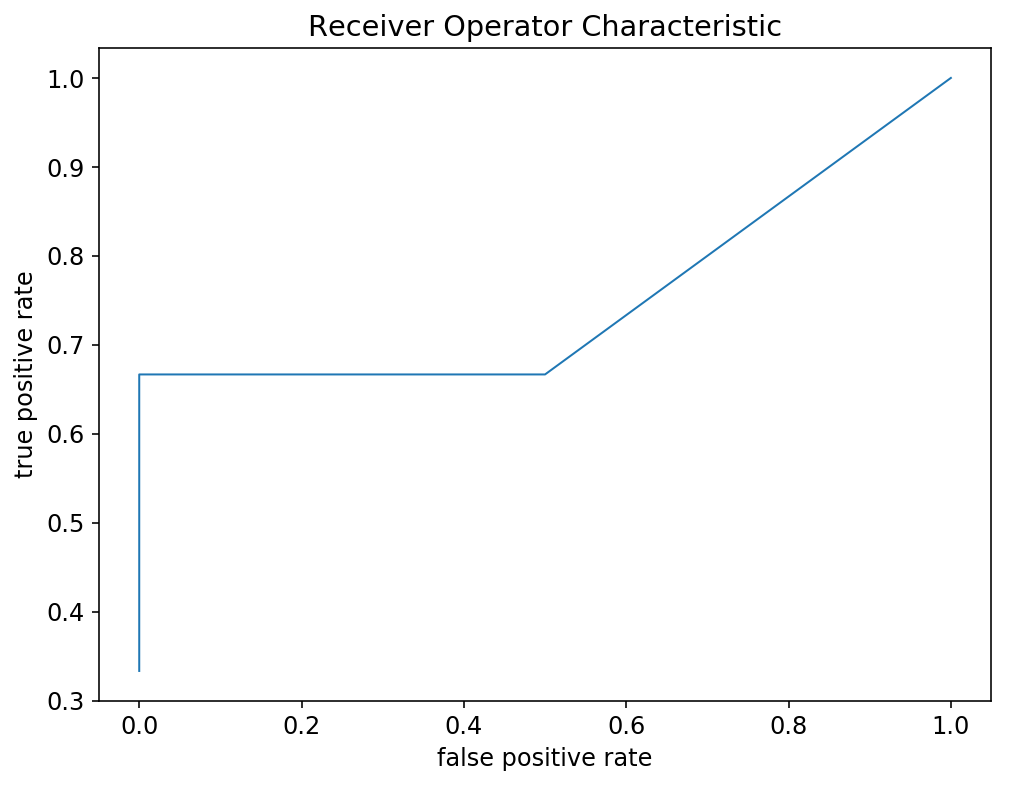

In [16]:
# convert count to rate
tpr = tps / tps[-1]
fpr = fps / fps[-1]

plt.plot(fpr, tpr, lw = 1)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.show()

Now to calculate the AUC (Area Under the Curve)

In [17]:
def _roc_auc_score(y_true, y_score):
    """
    Compute Area Under the Curve (AUC) from prediction scores

    Parameters
    ----------
    y_true : 1d nd.array, shape = [n_samples]
        True targets/labels of binary classification

    y_score : 1d nd.array, shape = [n_samples]
        Estimated probabilities or scores

    Returns
    -------
    auc : float
    """

    # ensure the target is binary
    if np.unique(y_true).size != 2:
        raise ValueError('Only two class should be present in y_true. ROC AUC score '
                         'is not defined in that case.')
    
    tps, fps, _ = _binary_clf_curve(y_true, y_score)

    # convert count to rate
    tpr = tps / tps[-1]
    fpr = fps / fps[-1]

    # compute AUC using the trapezoidal rule;
    # appending an extra 0 is just to ensure the length matches
    zero = np.array([0])
    tpr_diff = np.hstack((np.diff(tpr), zero))
    fpr_diff = np.hstack((np.diff(fpr), zero))
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc

In [19]:
from sklearn.metrics import roc_auc_score

auc = _roc_auc_score(y_true, y_score)
print('auc score:', auc)

# confirm with scikit-learn's result
auc = roc_auc_score(y_true, y_score)
print('package auc socre:', auc)

auc score: 0.75
package auc socre: 0.75


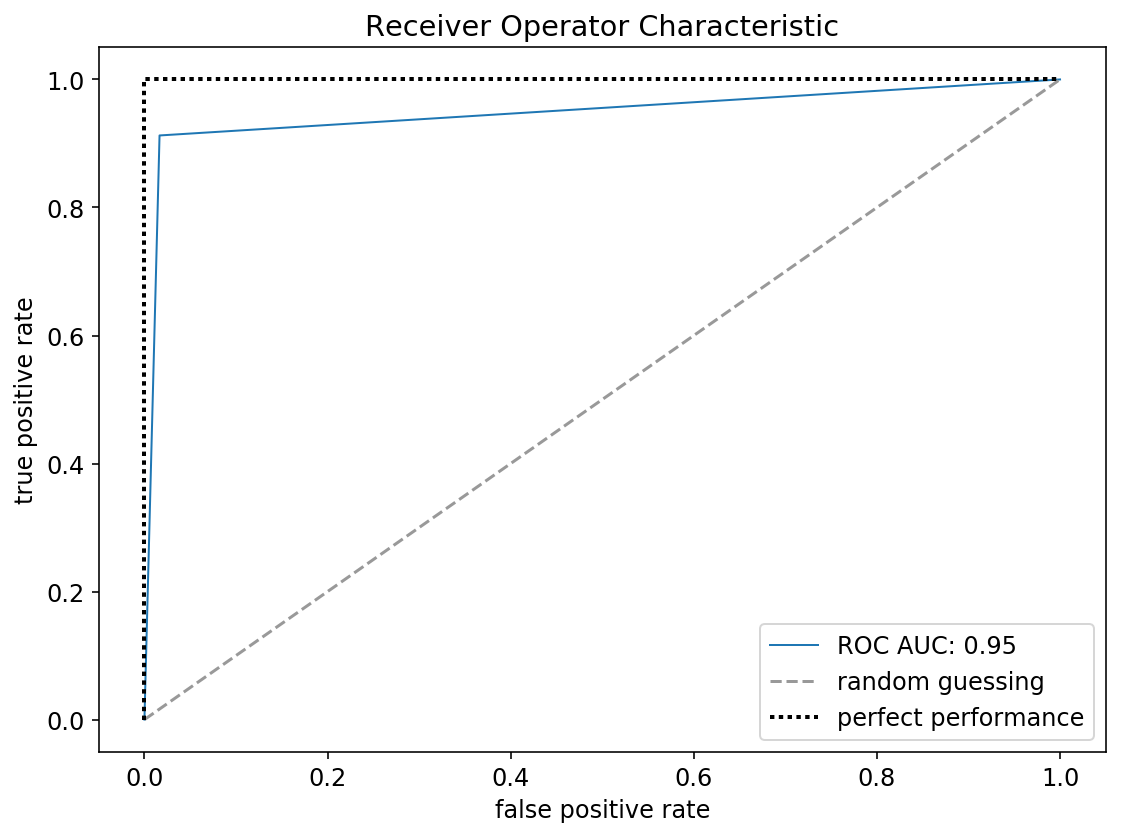

In [8]:
from sklearn.metrics import roc_curve, auc


# calling the roc_curve, extract the probability of 
# the positive class from the predicted probability
tree_test_pred = tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, tree_test_pred, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc = auc(fpr, tpr)


plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(fpr, tpr, lw = 1, label = 'ROC AUC: {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':', lw = 2,
         color = 'black', 
         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [9]:
tree_train_pred = tree.predict_proba(X_train)[:, 1]
tree_test_pred = tree.predict_proba(X_test)[:, 1]
tree_train_auc = roc_auc_score(y_train, tree_train_pred)
tree_test_auc = roc_auc_score(y_test, tree_test_pred)
print('train auc', tree_train_auc)
print('test auc', tree_test_auc)

train auc 0.999999960937
test auc 0.948


In [10]:
hi

NameError: name 'hi' is not defined

In [ ]:
from sklearn.metrics import accuracy_score
tree_train_pred = tree.predict(X_train)
tree_test_pred = tree.predict(X_test)
tree_train_accuracy = accuracy_score(y_train, tree_train_pred)
tree_test_accuracy = accuracy_score(y_test, tree_test_pred)
print('train accuracy', tree_train_accuracy)
print('test accuracy', tree_test_accuracy)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_score)
y_true = np.array([1, 0, 1, 0, 1])
y_score = np.array([0.45, 0.4, 0.35, 0.35, 0.8])



roc_auc_score(y_true, y_score)

In [ ]:
zero = np.array([0])
tpr_diff = np.hstack((np.diff(tpr), zero))
fpr_diff = np.hstack((np.diff(fpr), zero))
auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
auc

In [ ]:
tpr

In [ ]:
tpr_diff

In [ ]:
fpr_diff

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, lw = 1)
plt.show()

In [ ]:
# 0.75
# y_true = np.array([0, 0, 1, 1])
# y_score = np.array([0.1, 0.4, 0.35, 0.8])
# roc_auc_score(y_true, y_score)

In [ ]:
def _binary_roc_auc_score(y_true, y_score, sample_weight=None):
    fpr, tpr, tresholds = roc_curve(y_true, y_score,
                                    sample_weight=sample_weight)
    return auc(fpr, tpr, reorder=True)

return _average_binary_score(
    _binary_roc_auc_score, y_true, y_score, average,
    sample_weight=sample_weight)

While AUC gives a single-number summary of classifier performance that is suitable in some circumstances, other metrics are often more appropriate. For binary classifiers, evaluation metrics that take into account the actual costs of false positive and false negative errors may be much more appropriate than AUC. If we know these costs, we can use them not only to tie to more directly to the business value but also choose the final cutoff threhold for the classifier.

In real world application, the cost that comes along with making these two mistakes (false positive and false negative) are usually a whole lot different. Take our case for example, a false negative (FN) means an employee left our company but our model failed to detect that, while a false positive (FP) means an employee is still currently working at our company and our model told us that they will be leaving. The former mistake would be a tragedy, since, well, the emplyoee left and we didn’t do anything about it! As for conducting the latter mistake, we might be wasting like 15 minutes of a HR manager's time when we arrange a face to face interview with a employee, questioning about how the company can do better to retain him, while he's perfectly fine with the current situation.

# Reference

- [Blog: Calculating AUC: the area under a ROC Curve](http://blog.revolutionanalytics.com/2016/11/calculating-auc.html)